# Make figure 5 of paper
23/03/2025

Data from Peng et al. 2015 was provided kindly by Y. Pang on reqest. The data, though used in this plot, will not be included in the data files associated with this paper. Please make your own requests if you want to reproduce those lines on this plot.

In [1]:
import bagpipes as pipes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import pandas as pd

plt.rcParams.update({'font.size': 16})
import seaborn as sns
import os
from bagpipes import plotting
pipes.plotting.update_rcParams()
matplotlib.rcParams["axes.linewidth"] = 1.0

Starting dense_basis. Failed to load FSPS, only GP-SFH module will be available.


In [2]:
# change working directory to one layer above
os.chdir('..')
# set saving direction
save_dir = 'plots/'

In [27]:
# load in percentiles and samples tables
CPSB_post_df = pd.read_csv('data/posterior_samples_CPSB.csv')
RPSB_post_df = pd.read_csv('data/posterior_samples_RPSB_PSB.csv')
CPSB_percentiles = pd.read_csv('data/posterior_percentiles_CPSB.csv')
RPSB_percentiles = pd.read_csv('data/posterior_percentiles_RPSB_PSB.csv')

In [28]:
# remove PSBs with bad GP noise fits
CPSB_percentiles_ = CPSB_percentiles[CPSB_percentiles['GPnoise_flag']==0]
RPSB_percentiles_ = RPSB_percentiles[RPSB_percentiles['GPnoise_flag']==0]

In [6]:
# check if Peng2015 data exists
if 'peng2015' in os.listdir('data'):
    peng2015_exists = True
else:
    peng2015_exists = False

In [7]:
# functions to reconstruct the MZ lines in literature

def panter2008(logMstar):
    # From Panter et al. 2008, section 6, equation 1
    # https://ui.adsabs.harvard.edu/abs/2008MNRAS.391.1117P/abstract
    A = -0.452
    B = 0.572
    logMc = 9.66
    delta = 1.04
    # adjust Zsun scale too
    return A + B*np.tanh((logMstar-logMc)/delta) + np.log10(0.02/0.0142)

def gallazi2005():
    # From Gallazzi et al. 2005, Table 2
    # https://ui.adsabs.harvard.edu/abs/2005MNRAS.362...41G/abstract
    # log Mstar, zmet_50, zmet_16, zmet_84
    table = """
       8.91     -0.60  -1.11     -0.00 
       9.11     -0.61  -1.07     -0.00 
       9.31     -0.65  -1.10     -0.05 
       9.51     -0.61  -1.03     -0.01 
       9.72     -0.52  -0.97      0.05 
       9.91     -0.41  -0.90      0.09 
      10.11     -0.23  -0.80      0.14 
      10.31     -0.11  -0.65      0.17 
      10.51     -0.01  -0.41      0.20 
      10.72      0.04  -0.24      0.22 
      10.91      0.07  -0.14      0.24 
      11.11      0.10  -0.09      0.25 
      11.31      0.12  -0.06      0.26 
      11.51      0.13  -0.04      0.28 
      11.72      0.14  -0.03      0.29 
      11.91      0.15  -0.03      0.30 
      """
    table_array = np.genfromtxt(table.splitlines())
    table_array_ = table_array[:,[0,2,1,3]]
    # adjust Zsun scale
    table_array_[:,1:] += np.log10(0.02/0.0142)
    return table_array_

def peng2015_LW():
    # From Peng et al. 2015, Figure 2
    # https://ui.adsabs.harvard.edu/abs/2015Natur.521..192P/abstract
    # data kindly provided by Y. Peng on request
    passive_array = np.genfromtxt('data/peng2015/passive.txt')
    passive_df = pd.DataFrame(passive_array, columns=['Mstar', 'passive_logZ', 'passive_logZ_err'])
    # adjust Zsun scale
    passive_df['passive_logZ'] += np.log10(0.02/0.0142)
    sfing_array = np.genfromtxt('data/peng2015/starforming.txt')
    sfing_df = pd.DataFrame(sfing_array, columns=['Mstar', 'sfing_logZ', 'sfing_logZ_err'])
    # adjust Zsun scale
    sfing_df['sfing_logZ'] += np.log10(0.02/0.0142)
    df = sfing_df.merge(passive_df, on='Mstar', how='outer')
    return df

In [23]:
def plot_panel(ax, 
               CPSB_xvals, CPSB_yvals, CPSB_xerr, CPSB_yerr, CPSB_mask, 
               RPSB_xvals, RPSB_yvals, RPSB_xerr, RPSB_yerr, RPSB_mask
              ):
    CPSB_xerr = np.array(CPSB_xerr)
    CPSB_yerr = np.array(CPSB_yerr)
    RPSB_xerr = np.array(RPSB_xerr)
    RPSB_yerr = np.array(RPSB_yerr)
    
    # type 1
    ax.scatter(CPSB_xvals[CPSB_mask], CPSB_yvals[CPSB_mask], 
                  color=colour1, marker=marker1, zorder=4.8, label=label1)
    ax.errorbar(CPSB_xvals[CPSB_mask], CPSB_yvals[CPSB_mask], 
                   xerr=CPSB_xerr[:,CPSB_mask], 
                   yerr=CPSB_yerr[:,CPSB_mask],
                   color=colour1, alpha=0.5, fmt='.', zorder=4.5)
    
    ax.scatter(RPSB_xvals[RPSB_mask], RPSB_yvals[RPSB_mask], 
              facecolors='white', edgecolors=colour1, marker=marker1, zorder=4.8)
    ax.errorbar(RPSB_xvals[RPSB_mask], RPSB_yvals[RPSB_mask], 
                   xerr=RPSB_xerr[:,RPSB_mask], 
                   yerr=RPSB_yerr[:,RPSB_mask],
                   color=colour1, alpha=0.5, fmt='.', zorder=4.5)
    
    # type 2
    ax.scatter(CPSB_xvals[~CPSB_mask], CPSB_yvals[~CPSB_mask], 
                  color=colour2, marker=marker2, zorder=4.7, label=label2)
    ax.errorbar(CPSB_xvals[~CPSB_mask], CPSB_yvals[~CPSB_mask], 
                   xerr=CPSB_xerr[:,~CPSB_mask], 
                   yerr=CPSB_yerr[:,~CPSB_mask],
                   color=colour2, alpha=0.5, fmt='.', zorder=4.5)
    
    ax.scatter(RPSB_xvals[~RPSB_mask], RPSB_yvals[~RPSB_mask], 
              facecolors='white', edgecolors=colour2, marker=marker2, zorder=4.7)
    ax.errorbar(RPSB_xvals[~RPSB_mask], RPSB_yvals[~RPSB_mask], 
                   xerr=RPSB_xerr[:,~RPSB_mask], 
                   yerr=RPSB_yerr[:,~RPSB_mask],
                   color=colour2, alpha=0.5, fmt='.', zorder=4.5)
        
def add_literature_lines(ax, Mstar_relation):
    lims = [ax.get_xlim(), ax.get_ylim()]
    
    # panter2008
    ax.plot(Mstar_relation, panter2008(Mstar_relation), color='cyan', zorder=0)
    
    #gallazi2005
    gallazi2005_lines = gallazi2005()
    ax.plot(gallazi2005_lines[:,0], gallazi2005_lines[:,2], color='black', zorder=0)
    ax.plot(gallazi2005_lines[:,0], gallazi2005_lines[:,1], color='black', ls='--', lw=1, zorder=0)
    ax.plot(gallazi2005_lines[:,0], gallazi2005_lines[:,3], color='black', ls='--', lw=1, zorder=0)
    
    # peng2015
    if peng2015_exists:
        peng2015_lines = peng2015_LW()
        ax.plot(peng2015_lines['Mstar'], peng2015_lines['sfing_logZ'], color='C0', zorder=0)
        ax.fill_between(peng2015_lines['Mstar'], peng2015_lines['sfing_logZ']-peng2015_lines['sfing_logZ_err'], 
                           peng2015_lines['sfing_logZ']+peng2015_lines['sfing_logZ_err'], 
                           color='C0', alpha=0.2, zorder=-1)
        ax.plot(peng2015_lines['Mstar'], peng2015_lines['passive_logZ'], color='C3', zorder=0)
        ax.fill_between(peng2015_lines['Mstar'], 
                           peng2015_lines['passive_logZ']-peng2015_lines['passive_logZ_err'], 
                           peng2015_lines['passive_logZ']+peng2015_lines['passive_logZ_err'], 
                           color='C3', alpha=0.2, zorder=-1)
    
    ax.set_xlim(lims[0])

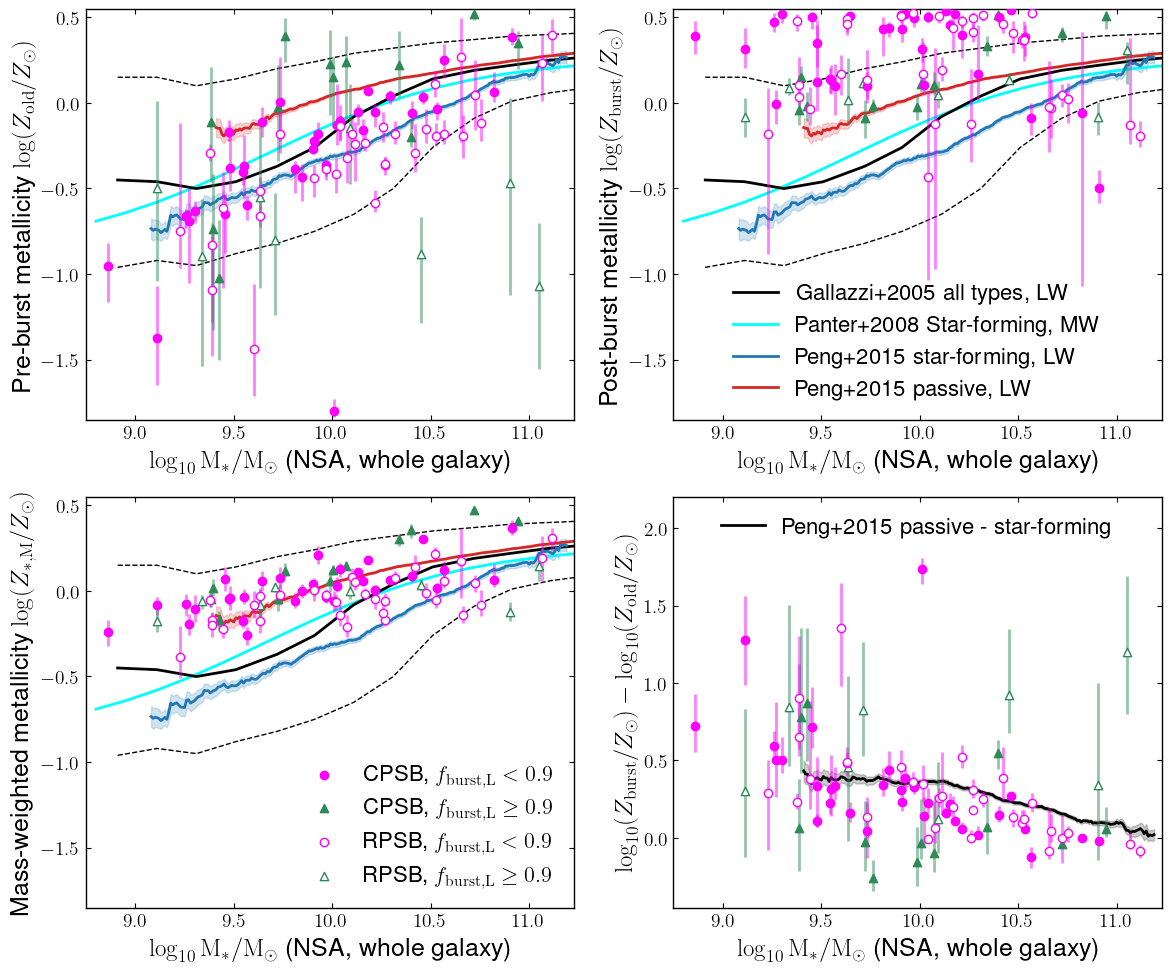

In [33]:
Mstar_col = 'log_NSA_ELPETRO_MASS'

# create the figure and axes
fig, ax_ = plt.subplots(2,2, figsize=[12,10])
ax = [ax_[0,0], ax_[0,1], ax_[1,0], ax_[1,1]]

# param names and ylabels
params = ['log_metallicity_old', 'log_metallicity_burst', 'log_MW_zmet']
ylabels = ["Pre-burst metallicity $\\log(Z_\\mathrm{old}/Z_{\\odot})$",
           "Post-burst metallicity $\\log(Z_\\mathrm{burst}/Z_{\\odot})$", 
           "Mass-weighted metallicity $\\log(Z_\\mathrm{*,M}/Z_{\\odot})$",
           "$\\log_{10}(Z_\\mathrm{burst}/Z_\\odot) - \\log_{10}(Z_\\mathrm{old}/Z_\\odot)$"]

# used for plotting the lines in the literature
Mstar_relation = np.linspace(8.8,11.8,20)

# colours, markers and labels
colour1 = 'magenta'
marker1 = 'o'
label1 = '$f_\\mathrm{burst,L} < 0.9$'
colour2 = 'seagreen'
marker2 = '^'
label2 = '$f_\\mathrm{burst,L} \ge 0.9$'

# get data Mstar values
CPSB_Mstar_50 = np.array(CPSB_percentiles_[Mstar_col])
RPSB_Mstar_50 = np.array(RPSB_percentiles_[Mstar_col])
# dummy errors
CPSB_Mstar_err = [np.zeros(len(CPSB_Mstar_50))]*2
RPSB_Mstar_err = [np.zeros(len(RPSB_Mstar_50))]*2
    
# seperate the two types
CPSB_type1_bool = np.array(CPSB_percentiles_['fburst_light_50'] < 0.9)
RPSB_type1_bool = np.array(RPSB_percentiles_['fburst_light_50'] < 0.9)
        
#======== first three panels ========#
for i,param in enumerate(params):
    CPSB_zmet_median = np.array(CPSB_percentiles_[param+'_50'])
    RPSB_zmet_median = np.array(RPSB_percentiles_[param+'_50'])
    CPSB_zmet_err = [
        np.array(CPSB_percentiles_[param+'_50'] - CPSB_percentiles_[param+'_16']),
        np.array(CPSB_percentiles_[param+'_84'] - CPSB_percentiles_[param+'_50'])
    ]
    RPSB_zmet_err = [
        np.array(RPSB_percentiles_[param+'_50'] - RPSB_percentiles_[param+'_16']),
        np.array(RPSB_percentiles_[param+'_84'] - RPSB_percentiles_[param+'_50'])
    ]
    
    plot_panel(ax[i], 
               CPSB_Mstar_50, CPSB_zmet_median, CPSB_Mstar_err, CPSB_zmet_err, CPSB_type1_bool,
               RPSB_Mstar_50, RPSB_zmet_median, RPSB_Mstar_err, RPSB_zmet_err, RPSB_type1_bool,
              )
    
    ax[i].set_xlabel(r'$\log_{10}\mathrm{M_*/M_\odot}$ (NSA, whole galaxy)')
        
    ax[i].set_ylabel(ylabels[i])
    add_literature_lines(ax[i], Mstar_relation)
    ax[i].set_ylim(np.log10(np.array([0.01,2.5])*0.02/0.0142))
                       
# add legend for data in top left panel
s1 = ax[0].scatter([],[], color=colour1, marker=marker1)
s2 = ax[0].scatter([],[], color=colour2, marker=marker2)
s3 = ax[0].scatter([],[], edgecolors=colour1, facecolor='white', marker=marker1)
s4 = ax[0].scatter([],[], edgecolors=colour2, facecolor='white', marker=marker2)
ax[2].legend([s1, s2, s3, s4], ['CPSB, '+label1, 'CPSB, '+label2, 'RPSB, '+label1, 'RPSB, '+label2],
            fontsize=16, loc="lower right", frameon=False)


# add legend for literature lines in top right panel
ax[1].legend(
        handles=[
            mlines.Line2D([], [], color='k', label='Gallazzi+2005 all types, LW'),
            mlines.Line2D([], [], color='cyan', label='Panter+2008 Star-forming, MW'),
            mlines.Line2D([], [], color='C0', label='Peng+2015 star-forming, LW'),
            mlines.Line2D([], [], color='C3', label='Peng+2015 passive, LW'),
        ],
        fontsize=16, frameon=False, loc="lower center"
    )

#======== bottom right panel ========#
CPSB_medians = np.array(CPSB_percentiles_['log_MW_zmet_diff_50'])
RPSB_medians = np.array(RPSB_percentiles_['log_MW_zmet_diff_50'])
CPSB_zmet_err = [
    np.array(CPSB_percentiles_['log_MW_zmet_diff_50'] - CPSB_percentiles_['log_MW_zmet_diff_16']),
    np.array(CPSB_percentiles_['log_MW_zmet_diff_84'] - CPSB_percentiles_['log_MW_zmet_diff_50'])
]
RPSB_zmet_err = [
    np.array(RPSB_percentiles_['log_MW_zmet_diff_50'] - RPSB_percentiles_['log_MW_zmet_diff_16']),
    np.array(RPSB_percentiles_['log_MW_zmet_diff_84'] - RPSB_percentiles_['log_MW_zmet_diff_50'])
]

plot_panel(ax[-1], 
           CPSB_Mstar_50, CPSB_medians, CPSB_Mstar_err, CPSB_zmet_err, CPSB_type1_bool,
           RPSB_Mstar_50, RPSB_medians, RPSB_Mstar_err, RPSB_zmet_err, RPSB_type1_bool
          )

lims = [ax[-1].get_xlim(), ax[-1].get_ylim()]

# the peng2015 lines
if peng2015_exists:
    peng2015_lines = peng2015_LW()
    peng2015_lines['diff_logZ'] = peng2015_lines['passive_logZ'] - peng2015_lines['sfing_logZ']
    peng2015_lines['diff_logZ_err'] = np.sqrt(peng2015_lines['sfing_logZ_err']**2 + 
                                              peng2015_lines['passive_logZ_err']**2)
    ax[-1].plot(peng2015_lines['Mstar'], peng2015_lines['diff_logZ'], color='black', zorder=0)
    ax[-1].fill_between(peng2015_lines['Mstar'], peng2015_lines['diff_logZ']-peng2015_lines['diff_logZ_err'], 
                       peng2015_lines['diff_logZ']+peng2015_lines['diff_logZ_err'], 
                       color='black', alpha=0.2, zorder=-1)

# axis labels and limits
ax[-1].set_ylabel(ylabels[-1])
ax[-1].set_xlabel(r'$\log_{10}\mathrm{M_*/M_\odot}$ (NSA, whole galaxy)')
ax[-1].set_xlim(lims[0])
ax[-1].set_ylim(top=2.2)

# legend
ax[-1].legend(
        handles=[
            mlines.Line2D([], [], color='k', label='Peng+2015 passive - star-forming')
        ],
        fontsize=16, frameon=False, loc="upper center"
    )
    
fig.tight_layout()
#fig.savefig(save_dir+'CPSBvsRPSB_NSA_MvsZ.pdf', bbox_inches = 'tight')
plt.show()

In [34]:
fig.savefig(save_dir+'CPSBvsRPSB_NSA_MvsZ.pdf', bbox_inches='tight', dpi=150)